In [2]:
import pandas as pd

reviews_raw = pd.read_csv(r'_SELECT_text_review_review_id_FROM_t4_GROUP_BY_LIMIT_50000__202205041908.csv', sep=';')
reviews_raw

,text_review,review_id
0,Мне если честно аромат не очень.... Всегда ста...,75b8359b-2336-4759-880d-45c531c3470c
1,Туалетная вода от «Nina Ricci» - Nina L’Eau.Пр...,e7077664-72ae-49f5-a1b8-7b683fd07728
2,Очень приятный и свежий аромат. Ярко стартует ...,f99d2450-90dc-4914-9c02-6cf1d41de700
3,Cтал счастливым обладателем запечатанной миниа...,06fc790e-6dde-4835-ac00-5c1263884033
4,"Увидев на стенде Летуаль новинку от Shiseido, ...",4abc59a2-ebf0-44ed-b9fe-0ebe71f57807
...,...,...
49995,"Ох,гуччи гилти.Аромат моих «клубных» лет.Возмо...",d134f63f-76b4-4500-a74d-8d85d56d6e01
49996,Полное название продукта: ARMANI EAU D'AROMES ...,da4e2a00-0f13-42ed-88e5-a3f298345596
49997,Классика,026c5523-4a68-44b8-8faf-2c8f87f62acd
49998,"Достоинства: Яркий аромат,стойкость,DIOR.\nНед...",406c2e07-08a1-450f-a0e7-9b04313fe984


In [3]:
reviews_raw.duplicated(subset='text_review').sum()

14427

In [4]:
reviews_raw.drop_duplicates(subset='text_review', inplace=True)
reviews_raw.duplicated(subset='text_review').sum(), reviews_raw.duplicated(subset='review_id').sum()

(0, 0)

In [21]:
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
import re

with open ('stop_ru.txt', 'r') as stop_ru:
    rus_stops = [word.strip() for word in stop_ru.readlines()]
stopwords = rus_stops

parser = MorphAnalyzer()


def preprocess(input_text):
    """
    Функция для предобработки текста. Слова приводятся к нижнему регистру,
    стоп-слова удаляются, далее слова лемматизируются
    :param input_text: Входной текст для очистки и лемматизации
    :return: Очищенный и лемматизированный текст
    """
    text = re.sub(r'[^\w\s]', ' ', input_text)
    tokenized_text = word_tokenize(text)
    lemmatized_text = [parser.parse(word)[0].normal_form for word in tokenized_text]
    clean_text = [word for word in lemmatized_text if word not in stopwords]
    

    return clean_text

In [22]:
preprocess('Я хочу, «чтобы» во рту "оставался" честный!!! вкус сигарет l’eu.Конгруэнтно!!Ну что тут скажешь?примечательного Ничего')

['рот',
 'оставаться',
 'честный',
 'вкус',
 'сигарета',
 'l',
 'eu',
 'конгруэнтный',
 'примечательный']

In [9]:
# Лемматизация занимает довольно много времени, при этом было замечено, что процессор не загружен на 100%.
# Было решено использовать multiprocessing. Скорость выросла приблизительно в 6 раз (3 мин против 17 мин)
from multiprocessing import Pool
text_review = list(reviews_raw.text_review)
if __name__ == '__main__':
    pool = Pool(processes=10)
    preprocessed_text = pool.map(preprocess, text_review)
    pool.close()

In [10]:
reviews_raw['preprocessed_text'] = preprocessed_text
reviews_raw.head()

,text_review,review_id,preprocessed_text
0,Мне если честно аромат не очень.... Всегда ста...,75b8359b-2336-4759-880d-45c531c3470c,"[честно, аромат, стараться, прислушиваться, ар..."
1,Туалетная вода от «Nina Ricci» - Nina L’Eau.Пр...,e7077664-72ae-49f5-a1b8-7b683fd07728,"[туалетный, вода, nina, ricci, nina, l, eau, п..."
2,Очень приятный и свежий аромат. Ярко стартует ...,f99d2450-90dc-4914-9c02-6cf1d41de700,"[приятный, свежий, аромат, ярко, стартовать, ц..."
3,Cтал счастливым обладателем запечатанной миниа...,06fc790e-6dde-4835-ac00-5c1263884033,"[cталый, счастливый, обладатель, запечатать, м..."
4,"Увидев на стенде Летуаль новинку от Shiseido, ...",4abc59a2-ebf0-44ed-b9fe-0ebe71f57807,"[увидеть, стенд, летуаля, новинка, shiseido, с..."


In [11]:
import gensim
gensim_dictionary = gensim.corpora.Dictionary(reviews_raw['preprocessed_text'])
gensim_dictionary.filter_extremes(no_above=0.1, no_below=10)
gensim_dictionary.compactify()

In [342]:
len(gensim_dictionary)

13243

In [343]:
corpus = [gensim_dictionary.doc2bow(text) 
          for text in reviews_raw['preprocessed_text']]
len(corpus)

35573

In [351]:
lda_10 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=10, 
                                 id2word=gensim_dictionary, 
                                 passes=20, random_state=6457)

In [352]:
lda_10.print_topics()

[(0,
  '0.007*"зелёный" + 0.006*"malone" + 0.005*"jo" + 0.005*"свежесть" + 0.005*"весна" + 0.004*"прохладный" + 0.004*"летний" + 0.004*"сочный" + 0.004*"цитрус" + 0.004*"одеколон"'),
 (1,
  '0.005*"версия" + 0.004*"понять" + 0.004*"вообще" + 0.003*"затест" + 0.003*"ну" + 0.003*"нос" + 0.003*"вот" + 0.003*"да" + 0.003*"мочь" + 0.003*"разный"'),
 (2,
  '0.009*"guerlain" + 0.008*"туалетный" + 0.008*"достоинство" + 0.008*"недостаток" + 0.005*"комментарий" + 0.005*"покупать" + 0.005*"пользоваться" + 0.004*"покупка" + 0.004*"упаковка" + 0.004*"любимый"'),
 (3,
  '0.007*"gucci" + 0.004*"древесный" + 0.004*"сердце" + 0.004*"сандал" + 0.004*"аккорд" + 0.004*"вишня" + 0.004*"бергамот" + 0.004*"le" + 0.004*"иланга" + 0.003*"тонкий"'),
 (4,
  '0.007*"туалетный" + 0.007*"ива" + 0.007*"yves" + 0.007*"рош" + 0.007*"rocher" + 0.006*"объём" + 0.004*"упаковка" + 0.004*"подарок" + 0.004*"данный" + 0.004*"la"'),
 (5,
  '0.014*"armani" + 0.009*"giorgio" + 0.009*"чёрный" + 0.008*"si" + 0.006*"смородина" + 0

In [16]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_10,
                                     texts=reviews_raw["preprocessed_text"],
                                     dictionary=gensim_dictionary,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
 
print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.44656283065130575


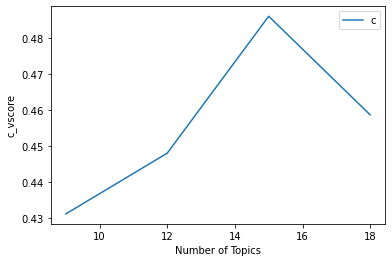

[0.43124669499555385, 0.44810920973604884, 0.4861004024521693, 0.45873788190435305]


In [17]:
def coherence_score(dictionary, corpus, texts, max, start=2, step=3,
                    measure="c_uci"):
    """
    Функция вычисляет метрики для оценки тем. моделирования и выводит 
    график, где по оси x отложено количество топиков, а по оси y — значение 
    метрики
    :param dictionary: словарь для тематического моделирования
    :param corpus: корпус в виде мешка слов
    :param texts: тексты документов
    :param max: максимальное количество топиков
    :param start: стартовое количество топиков
    :param step: промежуток, с которым вычисляются топики
    :param measure: метрика
    """
    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                           passes=20, num_topics=num_topics, 
                                           random_state=6457)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show()
    print(coherence_values)

import matplotlib.pyplot as plt
 
coherence_score(dictionary=gensim_dictionary, corpus=corpus, texts=reviews_raw["preprocessed_text"], start=9, max=20, step=3, measure="c_v")

In [95]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
 
vis_10 = gensimvis.prepare(lda_10, corpus, gensim_dictionary)
pyLDAvis.enable_notebook()
 
vis_10

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.037523  0.125731       1        1  19.736300
4      0.102755  0.028241       2        1  14.610265
2      0.114449  0.082360       3        1  13.433198
0     -0.096424 -0.036404       4        1  11.267117
5      0.066472 -0.033379       5        1   8.565054
3      0.018633 -0.076260       6        1   8.001730
8     -0.076380  0.002191       7        1   7.683413
9     -0.103448 -0.007030       8        1   6.387953
7      0.096148 -0.084480       9        1   5.294927
6     -0.084682 -0.000969      10        1   5.020042, topic_info=            Term         Freq        Total Category  logprob  loglift
2485        dior  2988.000000  2988.000000  Default  30.0000  30.0000
51           eau  4054.000000  4054.000000  Default  29.0000  29.0000
327       armani  3328.000000  3328.000000  Default  28.0000  28.0000
857       chanel  2396.000000  2396.000000  Default  27.0000  27.0000
1872         ива  2825.000000  2825.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
481        перец   285.928346  2641.944460  Topic10  -6.0220   0.7682
284      девушка   307.481223  3896.430001  Topic10  -5.9493   0.4523
355   интересный   286.998740  4005.002507  Topic10  -6.0183   0.3559
385            с   286.436089  4099.307462  Topic10  -6.0202   0.3307
397    фруктовый   280.840787  4187.014852  Topic10  -6.0399   0.2898

[787 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9925      1  0.946341       04
9925      2  0.010286       04
9925      3  0.041145       04
1123      1  0.411802       10
1123      2  0.174538       10
...     ...       ...      ...
630       9  0.050011     этот
630      10  0.048068     этот
8285      6  0.098693     юбер
8285      8  0.863565     юбер
4568      2  0.989687  явность

[3557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 6, 4, 9, 10, 8, 7])

In [19]:
def get_topic(words, lda):
    """
    Функция назначает документу наиболее вероятный топик
    :param words: лемматизированный текст документа
    :param lda: тематическая модель
    :return: список из наиболее вероятного топика 
    и его вероятности
    """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topic_dictionary = {}
    for topic in topics:
        topic_dictionary[topic[1]] = str((topic[0])) 
    main_probability = max(topic_dictionary)
    main_topic = topic_dictionary[main_probability]
    return [main_topic, main_probability]

In [ ]:
reviews_raw["lda_10"] = reviews_raw["preprocessed_text"].apply(get_topic, lda=lda_10)
reviews_raw["topic_10"] = reviews_raw["lda_10"].str[0]
reviews_raw["probability_10"] = reviews_raw["lda_10"].str[1]

In [21]:
get_topic('Аромат мне очень понравился. Древесный , немного мускусный. Очень мужественный , сильный свежий запах'.split(), lda_10)

['6', 0.69984573]

In [2]:
reviews_raw

,text_review,review_id,preprocessed_text
0,Мне если честно аромат не очень.... Всегда ста...,75b8359b-2336-4759-880d-45c531c3470c,"[я, честно, аромат, всегда, стараться, прислуш..."
1,Туалетная вода от «Nina Ricci» - Nina L’Eau.Пр...,e7077664-72ae-49f5-a1b8-7b683fd07728,"[туалетный, вода, nina, ricci, nina, l, eau, п..."
2,Очень приятный и свежий аромат. Ярко стартует ...,f99d2450-90dc-4914-9c02-6cf1d41de700,"[очень, приятный, свежий, аромат, ярко, старто..."
3,Cтал счастливым обладателем запечатанной миниа...,06fc790e-6dde-4835-ac00-5c1263884033,"[cталый, счастливый, обладатель, запечатать, м..."
4,"Увидев на стенде Летуаль новинку от Shiseido, ...",4abc59a2-ebf0-44ed-b9fe-0ebe71f57807,"[увидеть, стенд, летуаля, новинка, shiseido, с..."
...,...,...,...
49989,Не могу выразить восторга по поводу этого аром...,083c5d1c-d279-4f07-aa29-db0df92b479e,"[не, выразить, восторг, повод, аромат, на, выл..."
49990,"Jo Malone ""Osmanthus Blossom"" аромат ассоцииру...",93f27891-1fdf-4895-a2ad-56413a3a57d9,"[jo, malone, osmanthus, blossom, аромат, ассоц..."
49991,"Комментарий: Я так их ждала, не смотря на все ...",bd74a36e-a83d-4ecb-90ca-82f5de0ddc54,"[комментарий, я, ждать, смотреть, отзыв, рискн..."
49992,Новая пятерка вначале мне сильно напоминает ра...,d0b84c1c-a77d-4d56-a737-42ba8cc9cd17,"[новый, пятёрка, вначале, сильно, напоминать, ..."


In [93]:
#Let's try to generate 15 topics
lda_15 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=15, 
                                 id2word=gensim_dictionary, 
                                 passes=30, random_state=6457)

In [46]:
def get_topic_my(words, lda):
    """
    Функция назначает документу наиболее вероятный топик
    :param words: лемматизированный текст документа
    :param lda: тематическая модель
    :return: список из наиболее вероятного топика 
    и его вероятности
    """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topics.sort(key=lambda x: x[1], reverse=True)
    return topics[0]

In [90]:
vis_lda_15 = gensimvis.prepare(lda_15, corpus, gensim_dictionary)
vis_lda_15

/home/sandro/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/sandro/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sandro/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sandro/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sandro/miniconda3/lib/python3.9/site-packages/p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.031745 -0.131633       1        1  16.821144
4     -0.116968 -0.044434       2        1  14.929357
2     -0.129057 -0.098022       3        1   8.495960
0      0.148867  0.019753       4        1   8.004935
9      0.158811  0.009293       5        1   6.897939
8      0.105916  0.039393       6        1   6.801125
10     0.087709 -0.035813       7        1   6.121693
3     -0.019207  0.100210       8        1   6.116448
13    -0.040349  0.090113       9        1   5.034179
5     -0.069589  0.061392      10        1   5.021553
14    -0.050428 -0.042471      11        1   4.128973
7     -0.116603  0.056724      12        1   3.694239
11     0.038350 -0.099518      13        1   2.938644
12    -0.015289 -0.035219      14        1   2.601598
6     -0.013908  0.110233      15        1   2.392213, topic_info=         Term         Freq        Total Category  logprob  loglift
51        eau  4054.000000  4054.000000  Default  30.0000  30.0000
2485     dior  2986.000000  2986.000000  Default  29.0000  29.0000
553      yves  3578.000000  3578.000000  Default  28.0000  28.0000
1872      ива  2889.000000  2889.000000  Default  27.0000  27.0000
327    armani  3301.000000  3301.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
410       боб   184.707951  1539.656883  Topic15  -5.7177   1.6124
32    розовый   232.346330  4559.101935  Topic15  -5.4883   0.7563
518    тонкий   207.483226  3735.357028  Topic15  -5.6015   0.8424
734   молодой   173.962156  1830.678273  Topic15  -5.7777   1.3793
805    версия   186.271128  5356.832034  Topic15  -5.7093   0.3740

[1097 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
8824       1  0.147046        01
8824       2  0.005252        01
8824       3  0.840265        01
4624       1  0.164149        02
4624       3  0.828750        02
...      ...       ...       ...
4030       6  0.017995  ядовитый
4030       7  0.743786  ядовитый
4030       9  0.005998  ядовитый
4030      12  0.023993  ядовитый
11813     14  0.959749    ячмень

[5454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 10, 9, 11, 4, 14, 6, 15, 8, 12, 13, 7])

In [94]:
lda_15.print_topics()

[(0,
  '0.011*"зелёный" + 0.008*"свежесть" + 0.007*"весна" + 0.006*"летний" + 0.006*"прохладный" + 0.005*"воздух" + 0.005*"солнце" + 0.005*"цитрус" + 0.005*"сочный" + 0.005*"весенний"'),
 (1,
  '0.005*"понять" + 0.004*"вообще" + 0.004*"версия" + 0.004*"затест" + 0.004*"нос" + 0.004*"ну" + 0.003*"нанести" + 0.003*"вот" + 0.003*"так" + 0.003*"мочь"'),
 (2,
  '0.012*"достоинство" + 0.012*"недостаток" + 0.011*"guerlain" + 0.008*"комментарий" + 0.008*"туалетный" + 0.007*"пользоваться" + 0.007*"покупать" + 0.005*"mon" + 0.005*"любимый" + 0.005*"пробник"'),
 (3,
  '0.008*"иланга" + 0.007*"сердце" + 0.006*"белый" + 0.006*"givenchy" + 0.006*"бергамот" + 0.006*"сандал" + 0.005*"аккорд" + 0.005*"le" + 0.005*"амбра" + 0.004*"базовый"'),
 (4,
  '0.011*"туалетный" + 0.007*"объём" + 0.005*"упаковка" + 0.005*"флакончик" + 0.005*"коробочка" + 0.005*"данный" + 0.004*"la" + 0.004*"покупка" + 0.004*"рубль" + 0.004*"подарок"'),
 (5,
  '0.021*"armani" + 0.015*"giorgio" + 0.015*"si" + 0.011*"смородина" + 0.0

In [126]:
reviews_raw.text_review[0]

'Мне если честно аромат не очень.... Всегда стараюсь прислушиваться к ароматам "с чистого листа", то есть не опираясь ни на какую рекламу, ни на чужие мнения, ни на дизайн флакона, ни на крутость марки и т.п. Слушая этот аромат, чувствую от него холодок, резкозть, даже какую-то отталкивающую, одним словом мне он неуютен и от него веет какой-то тревожной ноткой, плюс ещё ощущение что запах какой-то уж слишком мужской. Так что к сожалению, с ним точно не подружусь, несмотря на его популярность, увы - не моё!  \nИ как я заметила, не одной мне тут чудятся мужские ноты. Как-то вот так, насчёт того что аромат сексуальный я бы тоже не сказала, цвет флакона розовым бы я к нему не подобрала, так что красивая реклама и маркетинг это одно, а то, что аромат совсем о другом - об этом уже и мало кто думает, вот такие вот лично мои впечатления... Конечно, все мы разные и у каждого своё восприятие, но по мне аромат не о лёгкости жизни, не о кокетстве и уж тем более не о сексе'

In [160]:
# В одном отзыве может быть несколько тем. Разобьём отзыв на предложения, посмотрим, улучшит ли это нашу модель
# В качестве sentenizer будем использовать razdel
from razdel import sentenize
[_.text for _ in sentenize(reviews_raw.text_review[0])]


['Мне если честно аромат не очень....',
 'Всегда стараюсь прислушиваться к ароматам "с чистого листа", то есть не опираясь ни на какую рекламу, ни на чужие мнения, ни на дизайн флакона, ни на крутость марки и т.п.',
 'Слушая этот аромат, чувствую от него холодок, резкозть, даже какую-то отталкивающую, одним словом мне он неуютен и от него веет какой-то тревожной ноткой, плюс ещё ощущение что запах какой-то уж слишком мужской.',
 'Так что к сожалению, с ним точно не подружусь, несмотря на его популярность, увы - не моё!',
 'И как я заметила, не одной мне тут чудятся мужские ноты.',
 'Как-то вот так, насчёт того что аромат сексуальный я бы тоже не сказала, цвет флакона розовым бы я к нему не подобрала, так что красивая реклама и маркетинг это одно, а то, что аромат совсем о другом - об этом уже и мало кто думает, вот такие вот лично мои впечатления...',
 'Конечно, все мы разные и у каждого своё восприятие, но по мне аромат не о лёгкости жизни, не о кокетстве и уж тем более не о сексе']

In [161]:
def split_to_sent(doc):
    return [_.text for _ in sentenize(doc)]

reviews_sent = reviews_raw.text_review.map(split_to_sent)

In [169]:
sent2doc = [sentense for review in reviews_sent for sentense in review]
sent2doc[:36]

['Мне если честно аромат не очень....',
 'Всегда стараюсь прислушиваться к ароматам "с чистого листа", то есть не опираясь ни на какую рекламу, ни на чужие мнения, ни на дизайн флакона, ни на крутость марки и т.п.',
 'Слушая этот аромат, чувствую от него холодок, резкозть, даже какую-то отталкивающую, одним словом мне он неуютен и от него веет какой-то тревожной ноткой, плюс ещё ощущение что запах какой-то уж слишком мужской.',
 'Так что к сожалению, с ним точно не подружусь, несмотря на его популярность, увы - не моё!',
 'И как я заметила, не одной мне тут чудятся мужские ноты.',
 'Как-то вот так, насчёт того что аромат сексуальный я бы тоже не сказала, цвет флакона розовым бы я к нему не подобрала, так что красивая реклама и маркетинг это одно, а то, что аромат совсем о другом - об этом уже и мало кто думает, вот такие вот лично мои впечатления...',
 'Конечно, все мы разные и у каждого своё восприятие, но по мне аромат не о лёгкости жизни, не о кокетстве и уж тем более не о сексе',
 

In [176]:
# Сравним скорость выполнения кода для list comprehension

%%time
sent2doc_preprocessed = [preprocess(sent) for sent in sent2doc]
sent2doc_preprocessed[:3]

1.92 s ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [177]:
# Сравним скорость выполнения кода для pd.Series.map

%%time
sent2doc_series = pd.Series(data=sent2doc[:1000])
sent2doc_series.map(preprocess)


1.92 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [190]:
# PyMystem решает задачу лемматизации значительно быстрее, чем PyMorphy (без multioricessing).
%%time
sent2doc_mystem = [mystem3.lemmatize(sent) for sent in sent2doc]
print(len(sent2doc_mystem), len(sent2doc))

358387 358387
CPU times: user 43.8 s, sys: 6.4 s, total: 50.2 s
Wall time: 3min 42s


In [254]:
from pymystem3 import Mystem
mystem3 = Mystem()
mystem3.lemmatize('Мне если честно аромат не очень')

['я', ' ', 'если', ' ', 'честно', ' ', 'аромат', ' ', 'не', ' ', 'очень', '\n']

In [245]:
# Однако, если использовать многопоточность, то pymorphy выигрывает по скорости более чем в 2 раза.
# "Прикрутить" multiprocessing к pymystem3 не удалось
%%time
from multiprocessing import Pool
if __name__ == '__main__':
    pool = Pool(processes=10)
    test_0 = pool.map(preprocess, sent2doc)
    pool.close()

CPU times: user 1.61 s, sys: 1 s, total: 2.62 s
Wall time: 1min 39s


In [355]:
sent2doc_preprocessed = test_0

In [356]:
gensim_dictionary_sent = gensim.corpora.Dictionary(sent2doc_preprocessed)
gensim_dictionary_sent.filter_extremes(no_above=0.1, no_below=10)
gensim_dictionary_sent.compactify()

In [357]:
len(gensim_dictionary_sent)

13732

In [358]:
corpus_sent = [gensim_dictionary_sent.doc2bow(text) 
          for text in sent2doc_preprocessed]
len(corpus_sent)

358387

In [359]:
lda_25_sent = gensim.models.LdaMulticore(corpus_sent, 
                                 num_topics=25, 
                                 id2word=gensim_dictionary_sent, 
                                 passes=20, random_state=6457)

In [360]:
lda_25_sent.print_topics()

[(23,
  '0.098*"стойкость" + 0.079*"шлейф" + 0.061*"час" + 0.054*"стойкий" + 0.032*"хороший" + 0.030*"достаточно" + 0.021*"5" + 0.020*"шлейфовый" + 0.019*"2" + 0.018*"3"'),
 (6,
  '0.038*"по" + 0.031*"показаться" + 0.023*"мера" + 0.022*"остаться" + 0.018*"простой" + 0.015*"начало" + 0.014*"конечно" + 0.013*"резкий" + 0.012*"удивить" + 0.011*"мыло"'),
 (2,
  '0.054*"пахнуть" + 0.027*"ощущение" + 0.024*"давать" + 0.021*"душа" + 0.020*"совершенно" + 0.020*"свежесть" + 0.018*"сладость" + 0.015*"запах" + 0.015*"придавать" + 0.014*"она"'),
 (24,
  '0.053*"женщина" + 0.048*"очень" + 0.039*"девушка" + 0.038*"мужчина" + 0.035*"подойти" + 0.018*"молодой" + 0.018*"видеть" + 0.016*"malone" + 0.016*"jo" + 0.014*"возраст"'),
 (7,
  '0.098*"флакон" + 0.023*"цвет" + 0.022*"упаковка" + 0.015*"флакончик" + 0.015*"коробочка" + 0.015*"вид" + 0.014*"крышка" + 0.014*"коробка" + 0.014*"дизайн" + 0.012*"чёрный"'),
 (22,
  '0.107*"я" + 0.045*"любить" + 0.043*"нравиться" + 0.037*"не" + 0.035*"понравиться" + 0.0

In [365]:
# После разбиения на предложения Coherence Score значительно вырос
coh_model_lda_25_sent = CoherenceModel(model=lda_25_sent,
                                     texts=sent2doc_preprocessed,
                                     corpus=corpus_sent,
                                     coherence="c_v")

coherence_lda = coh_model_lda_25_sent.get_coherence()
print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.6264739233876618


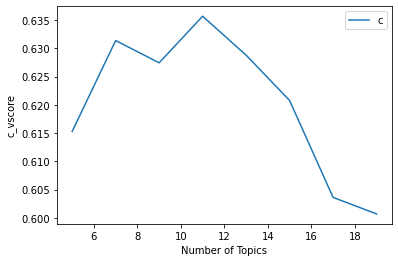

[0.6152975882038187, 0.6313993725989189, 0.6274510022265222, 0.6357006892858353, 0.628810087418429, 0.6207875594516103, 0.6036131381066836, 0.6006847738622344]


In [364]:
# Посмотрим, как меняется Coherence Score в зависимости от выбранного количества топиков
coherence_score(dictionary=gensim_dictionary_sent, corpus=corpus_sent, texts=sent2doc_preprocessed, start=5, max=20, step=2, measure="c_v")

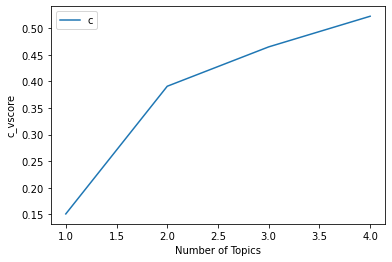

[0.15098593584314215, 0.3908250927492787, 0.464786026599372, 0.5223298314960374]


In [366]:
coherence_score(dictionary=gensim_dictionary_sent, corpus=corpus_sent, texts=sent2doc_preprocessed, start=1, max=5, step=1, measure="c_v")

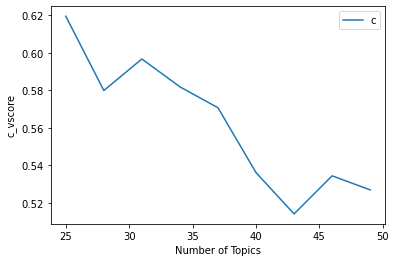

[0.6193777262765018, 0.5798769903290586, 0.5966536062481053, 0.5818245194296068, 0.5706927276863557, 0.5362040686815615, 0.5142363327658018, 0.5344912139530752, 0.5270236445594326]


In [368]:
coherence_score(dictionary=gensim_dictionary_sent, corpus=corpus_sent, texts=sent2doc_preprocessed, start=25, max=50, step=3, measure="c_v")

In [367]:
# Судя по графикам, наиболее оптимальное количество топиков - 12
lda_12_sent = gensim.models.LdaMulticore(corpus_sent, 
                                 num_topics=12, 
                                 id2word=gensim_dictionary_sent, 
                                 passes=20, random_state=6457)
lda_12_sent.print_topics()

[(0,
  '0.098*"нота" + 0.031*"роза" + 0.023*"ваниль" + 0.019*"жасмина" + 0.018*"мускус" + 0.016*"пирамида" + 0.016*"пачули" + 0.014*"верхний" + 0.012*"слышать" + 0.012*"сердце"'),
 (1,
  '0.025*"лето" + 0.022*"стойкость" + 0.019*"носить" + 0.018*"хороший" + 0.016*"шлейф" + 0.016*"весна" + 0.016*"настроение" + 0.014*"для" + 0.012*"подойти" + 0.012*"летний"'),
 (2,
  '0.017*"сладость" + 0.013*"свежесть" + 0.011*"в" + 0.010*"давать" + 0.009*"звучать" + 0.009*"придавать" + 0.008*"ощущение" + 0.008*"он" + 0.008*"нотка" + 0.007*"она"'),
 (3,
  '0.045*"мл" + 0.028*"купить" + 0.025*"магазин" + 0.023*"цена" + 0.022*"объём" + 0.021*"флакон" + 0.019*"30" + 0.015*"100" + 0.015*"пробник" + 0.014*"50"'),
 (4,
  '0.033*"я" + 0.020*"любить" + 0.020*"нравиться" + 0.019*"парфюм" + 0.019*"мой" + 0.017*"понравиться" + 0.016*"но" + 0.012*"рекомендовать" + 0.010*"девушка" + 0.009*"внимание"'),
 (5,
  '0.049*"вода" + 0.045*"отзыв" + 0.031*"парфюмерный" + 0.025*"туалетный" + 0.022*"весь" + 0.016*"достоинство"